# 6. 영화리뷰 텍스트 감성분석하기

---

## 목차

### 1) 데이터 준비와 확인
활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)입니다.

### 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
- 
### 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 5) 모델 훈련 개시

### 6) Loss, Accuracy 그래프 시각화

### 7) 학습된 Embedding 레이어 분석

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

위 링크에서 적절한 ko.bin을 찾아 이용하세요. 그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

---

## 6-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
- 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)

#### **참고: [Colab 에 konlpy 와 mecab 설치](https://sanghyu.tistory.com/170)**
```bash
# 1. bash 셀로 명령어를 입력하여 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy
```
```bash
# 2. jdk 환경 변수 설정
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"
```
```bash
# 3. mecab 설치
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996
```

In [4]:
# 라이브러리 불러오기
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import tensorflow as tf
import os

import matplotlib.pyplot as plt

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1228k      0  0:00:01  0:00:01 --:--:-- 8766k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

### 1) 데이터 준비와 확인
긍정 1, 부정 0 으로 라벨링

In [5]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('drive/MyDrive/Colab Notebooks/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('drive/MyDrive/Colab Notebooks/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
  train_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
  train_data = train_data.dropna(how = 'any')  # NaN 결측치 제거
  test_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
  test_data = test_data.dropna(how = 'any')  # NaN 결측치 제거
  
  X_train = []  # 학습용 데이터
  for sentence in train_data['document']:
      temp_X = tokenizer.morphs(sentence) # 토큰화
      temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
      X_train.append(temp_X)  # 단어 저장

  X_test = []  # 테스트용 데이터
  for sentence in test_data['document']:
      temp_X = tokenizer.morphs(sentence) # 토큰화
      temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
      X_test.append(temp_X)  # 단어 저장
  
  words = np.concatenate(X_train).tolist()  # array 합치고 list로 변환
  counter = Counter(words)  # list의 요소 개수 세기 => 딕셔너리 {단어: 개수} 형태로 반환
  counter = counter.most_common(10000-4)  # 최빈값 (10000-4)개 => 가장 마지막 4개를 제외한 나머지
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 단어 저장 list # <PAD>, <BOS>, <UNK>, <UNUSED>
  word_to_index = {word:index for index, word in enumerate(vocab)}  # 딕셔너리 {단어: 인덱스} 형태
  
  # 중첩 함수
  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
      
  # list(map(함수, 리스트)): 리스트의 모든 요소를 지정된 함수로 처리한 결과를 리스트로 만듦
  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))
      
  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [7]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포

In [10]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


- 적절한 최대 문장 길이 지정

In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
# 짧은 문장 앞(pre)에 패딩 추가. post보다 pre가 효율이 더 좋음!
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)  # (146182, 41)
print(X_test.shape)  # (49157, 41)

(146182, 41)
(49157, 41)


### 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [13]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. (변경 가능한 하이퍼 파라미터)

- Model 1: LSTM

In [14]:
# 모델 1: RNN 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


- Model 2: 1-D CNN

In [15]:
# 모델 2: 1-D CNN

model_1d_cnn = tf.keras.Sequential()
model_1d_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_1d_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1d_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1d_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1d_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

- Model 3: GlobalMaxPooling1D() 레이어 1개만 사용

In [16]:
# 모델 3: GlobalMaxPooling1D() 레이어 1개만 사용

model_gmp1d = tf.keras.Sequential()
model_gmp1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp1d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         2000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 1608      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [17]:
# Train : Validation : Test 을 일반적으로 6 : 2 : 2로 이용

# 일반적으로 전체 데이터 중 80%를 학습으로, 20%를 검증으로 사용하는 것이 좋다고 한다.
# validation set (총 데이터 개수 * 0.2)건 분리
x_val_len = int(len(X_train)*0.2)
y_val_len = int(len(y_train)*0.2)

x_val = X_train[:x_val_len]   
y_val = y_train[:y_val_len]

print(x_val.shape)  # (29236, 41)
print(y_val.shape)  # (29236,)

# validation set을 제외한 나머지 (총 데이터 개수 * 0.8)건
partial_x_train = X_train[x_val_len:]  
partial_y_train = y_train[y_val_len:]

print(partial_x_train.shape)  # (116946, 41)
print(partial_y_train.shape)  # (116946,)

(29236, 41)
(29236,)
(116946, 41)
(116946,)


#### **참고: [Early Stopping 의 개념과 Keras 를 통한 구현](https://3months.tistory.com/424)**
너무 많은 Epoch 은 overfitting 을 일으킨다. 하지만 너무 적은 Epoch 은 underfitting 을 일으킨다. 

=> Epoch 을 정할 때 Early stopping 을 사용한다! Early stopping 은 무조건 Epoch 을 많이 돌린 후, 특정 시점에서 멈추는 것이다.

In [18]:
from keras.callbacks import EarlyStopping

# monitor='val_loss': validation set 의 loss 를 monitoring 한다.
# mode='min': loss 의 경우, performance measure가 최소화 시키는 방향으로 training 이 진행되므로 min 을 지정한다. => keras에서 알아서 적절한 epoch에서 training을 멈춘다.
# verbose=1: 언제 keras 에서 training 을 멈추었는지를 화면에 출력할 수 있다.
# patience=5: patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 주관적 기준으로 정의한다. 성능이 증가하지 않는다고 바로 멈추는 것은 효과적이지 않을 수 있기 때문이다. 사용한 데이터와 모델의 설계에 따라 최적의 값이 바뀔 수 있다. 
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

- Model 1: LSTM

In [19]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
229/229 [==============================] - 27s 109ms/step - loss: 0.4387 - accuracy: 0.8103 - val_loss: 0.3482 - val_accuracy: 0.8498
Epoch 2/5
229/229 [==============================] - 24s 107ms/step - loss: 0.3185 - accuracy: 0.8662 - val_loss: 0.3327 - val_accuracy: 0.8540
Epoch 3/5
229/229 [==============================] - 24s 106ms/step - loss: 0.2850 - accuracy: 0.8809 - val_loss: 0.3420 - val_accuracy: 0.8541
Epoch 4/5
229/229 [==============================] - 24s 107ms/step - loss: 0.2577 - accuracy: 0.8935 - val_loss: 0.3428 - val_accuracy: 0.8544
Epoch 5/5
229/229 [==============================] - 24s 107ms/step - loss: 0.2323 - accuracy: 0.9047 - val_loss: 0.3602 - val_accuracy: 0.8531


In [20]:
# 모델 평가
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_lstm)  # (0.3595, 0.8507)

1537/1537 - 6s - loss: 0.3667 - accuracy: 0.8479 - 6s/epoch - 4ms/step
[0.36666378378868103, 0.8479158878326416]


- Model 2: 1-D CNN

In [21]:
model_1d_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1d_cnn = model_1d_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
229/229 [==============================] - 37s 160ms/step - loss: 0.4387 - accuracy: 0.7907 - val_loss: 0.3404 - val_accuracy: 0.8519
Epoch 2/5
229/229 [==============================] - 36s 158ms/step - loss: 0.3004 - accuracy: 0.8741 - val_loss: 0.3326 - val_accuracy: 0.8543
Epoch 3/5
229/229 [==============================] - 36s 158ms/step - loss: 0.2395 - accuracy: 0.9053 - val_loss: 0.3391 - val_accuracy: 0.8584
Epoch 4/5
229/229 [==============================] - 36s 158ms/step - loss: 0.1718 - accuracy: 0.9372 - val_loss: 0.3820 - val_accuracy: 0.8519
Epoch 5/5
229/229 [==============================] - 36s 158ms/step - loss: 0.1117 - accuracy: 0.9624 - val_loss: 0.4451 - val_accuracy: 0.8475


In [22]:
# 모델 평가
results_1d_cnn = model_1d_cnn.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_1d_cnn)  # (0.4455, 0.8416)

1537/1537 - 4s - loss: 0.4554 - accuracy: 0.8424 - 4s/epoch - 3ms/step
[0.45540377497673035, 0.8424029350280762]


- Model 3: GlobalMaxPooling1D() 1개만 사용

In [23]:
model_gmp1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp1d = model_gmp1d.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
229/229 [==============================] - 11s 45ms/step - loss: 0.4748 - accuracy: 0.8013 - val_loss: 0.3482 - val_accuracy: 0.8472
Epoch 2/5
229/229 [==============================] - 10s 45ms/step - loss: 0.3153 - accuracy: 0.8666 - val_loss: 0.3333 - val_accuracy: 0.8552
Epoch 3/5
229/229 [==============================] - 10s 45ms/step - loss: 0.2682 - accuracy: 0.8900 - val_loss: 0.3379 - val_accuracy: 0.8557
Epoch 4/5
229/229 [==============================] - 10s 45ms/step - loss: 0.2286 - accuracy: 0.9101 - val_loss: 0.3503 - val_accuracy: 0.8549
Epoch 5/5
229/229 [==============================] - 10s 45ms/step - loss: 0.1888 - accuracy: 0.9299 - val_loss: 0.3710 - val_accuracy: 0.8533


In [24]:
# 모델 평가
results_gmp1d = model_gmp1d.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_gmp1d)  # (0.3809, 0.8474)

1537/1537 - 2s - loss: 0.3834 - accuracy: 0.8461 - 2s/epoch - 1ms/step
[0.38342639803886414, 0.8461053371429443]


- Model 비교 (loss, accuracy)

|Num|Model|Loss|Accuracy|
|:---:|:---:|:---:|:---:|
|1|LSTM|0.3595|0.8507|
|2|1-D CNN|0.4455|0.8416|
|3|GlobalMaxPooling1D() 레이어 1개|0.3809|0.8474|

세 모델 다 성능이 비슷하다. 그 중에서 상대적으로 LSTM 성능이 제일 좋다.
- accuracy만 생각하면 LSTM 성능이 제일 좋다.
- loss만 생각하면 LSTM 성능이 제일 좋다.

### 6) Loss, Accuracy 그래프 시각화

- Model 1: LSTM

In [25]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

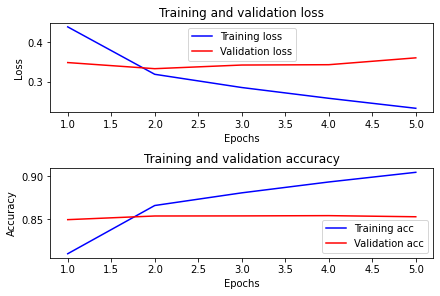

In [27]:
# Subplot들의 간격 조정하기 참고: https://tempdev.tistory.com/35

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

- Model 2: 1-D CNN

In [28]:
history_dict = history_1d_cnn.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

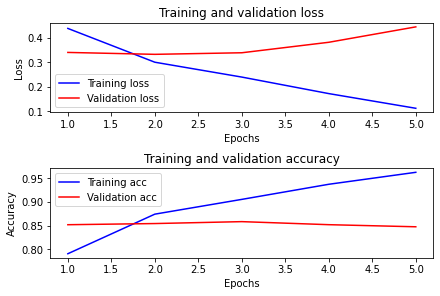

In [30]:
# Subplot들의 간격 조정하기 참고: https://tempdev.tistory.com/35

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

- Model 3: GloablMaxPooling1D()  레이어 1개만 사용

In [31]:
history_dict = history_gmp1d.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [32]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

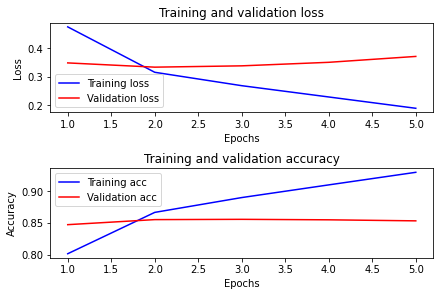

In [33]:
# Subplot들의 간격 조정하기 참고: https://tempdev.tistory.com/35

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

### 7) 학습된 Embedding 레이어 분석

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

- Model 1: LSTM

In [35]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'drive/MyDrive/Colab Notebooks/sentiment_classification/data/word2vec_LSTTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 1.15599511e-02, -3.59604508e-02,  1.51203508e-02,  1.89386144e-01,
        5.75726740e-02,  2.73495000e-02,  1.68933660e-01, -7.67221227e-02,
        1.17870811e-02,  1.64730400e-02, -1.94924660e-02, -3.31952944e-02,
       -9.97470506e-03,  6.26773909e-02,  8.14430043e-02,  3.93945538e-02,
       -1.29168347e-01,  1.49938852e-01,  7.31094107e-02, -9.43839084e-03,
       -6.83573782e-02,  9.68413148e-03, -2.68183276e-02,  7.90559351e-02,
        2.21854839e-02,  3.15193459e-02, -7.72445872e-02,  2.69467564e-04,
        7.53839016e-02,  9.49576199e-02,  6.06733561e-02,  9.53467563e-02,
       -5.11434898e-02,  4.29606698e-02, -1.21458821e-01,  4.56217863e-02,
        2.94061881e-02, -1.76502727e-02, -6.95532784e-02, -3.17792557e-02,
        1.05763242e-01, -1.70692783e-02,  1.66010652e-02, -6.05575070e-02,
        2.72291973e-02,  6.61186427e-02, -3.28605250e-03,  1.97056793e-02,
        2.85470393e-02, -9.69168246e-02, -5.85180819e-02, -2.78378930e-02,
        6.57828450e-02,  

In [38]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("재미")  # 유사 단어와 유사도 확인

[('완전', 0.757716178894043),
 ('넘', 0.7401788830757141),
 ('더불', 0.7306267023086548),
 ('너무', 0.7235556840896606),
 ('이리', 0.7154935002326965),
 ('띠', 0.7124409675598145),
 ('긴장감', 0.7105696201324463),
 ('기대', 0.7052869200706482),
 ('닿', 0.6945632100105286),
 ('거의', 0.6874486804008484)]

In [39]:
word_vectors.similar_by_word("최고")

[('명품', 0.8917285203933716),
 ('굿', 0.88321852684021),
 ('미소', 0.8820233941078186),
 ('흥미진진', 0.8697075843811035),
 ('아담스', 0.8673045039176941),
 ('완벽', 0.8664607405662537),
 ('신들린', 0.8623718619346619),
 ('따스', 0.8615207672119141),
 ('유머러스', 0.8603526949882507),
 ('탱고', 0.8556028008460999)]

In [40]:
word_vectors.similar_by_word("별로")

[('쓰레기', 0.8883030414581299),
 ('졸작', 0.8764959573745728),
 ('재미없', 0.8747398853302002),
 ('억지', 0.8687449097633362),
 ('어설픈', 0.8685830235481262),
 ('제로', 0.8680387139320374),
 ('따분', 0.8662077784538269),
 ('구림', 0.8648359775543213),
 ('꽝', 0.8611047267913818),
 ('뻔해서', 0.8603533506393433)]

In [41]:
word_vectors.similar_by_word("엉엉")

[('끌리', 0.8639836311340332),
 ('못지않', 0.8490253686904907),
 ('깨끗', 0.8455284833908081),
 ('명장면', 0.8426334857940674),
 ('최상', 0.8368562459945679),
 ('여사', 0.8356959819793701),
 ('고조', 0.8347816467285156),
 ('진하', 0.8337646722793579),
 ('쌀', 0.8337490558624268),
 ('후편', 0.8334569931030273)]

In [42]:
word_vectors.similar_by_word("매력")

[('유쾌', 0.7988952398300171),
 ('긴장감', 0.7773101329803467),
 ('캐', 0.7601171731948853),
 ('창의', 0.7469446659088135),
 ('미학', 0.7443838119506836),
 ('암튼', 0.7424423694610596),
 ('최소', 0.7421683073043823),
 ('소화', 0.7309916615486145),
 ('왤케', 0.7304494380950928),
 ('삶', 0.7279245257377625)]

In [43]:
word_vectors.similar_by_word("반전")

[('긴장감', 0.6452733278274536),
 ('모두', 0.6123091578483582),
 ('인정', 0.6122713685035706),
 ('로렌스', 0.6050076484680176),
 ('독특', 0.6021087169647217),
 ('또한', 0.5990393757820129),
 ('항상', 0.5943559408187866),
 ('어쨋든', 0.5876557230949402),
 ('진정', 0.5873904228210449),
 ('투쟁', 0.5847823023796082)]

- Model 2: 1-D CNN

In [44]:
embedding_layer = model_1d_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'drive/MyDrive/Colab Notebooks/sentiment_classification/data/word2vec_1-D_CNN.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_1d_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [46]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.04134703, -0.02434341, -0.02596116,  0.0071864 , -0.02185209,
       -0.0587077 , -0.01844174,  0.03430754,  0.00327818, -0.03799032,
        0.05521839,  0.03988498, -0.04963054,  0.04630915,  0.03676181,
       -0.01683879, -0.00232387, -0.11235008, -0.06199582, -0.13553055,
        0.02810752, -0.04475434,  0.00866413,  0.06013425, -0.09264623,
       -0.06783593, -0.11980495,  0.0358476 , -0.06785541, -0.01609808,
        0.00483533,  0.08515575,  0.08373234,  0.09358314, -0.02778801,
        0.02954536, -0.05550599, -0.01628357, -0.05057786, -0.13453467,
       -0.05892323,  0.07378894, -0.06506231, -0.0629918 ,  0.02726937,
       -0.0136245 ,  0.01256663,  0.0590753 ,  0.03902242,  0.00727947,
        0.06979833, -0.06752416, -0.02422572,  0.01719517, -0.00983879,
       -0.02463958, -0.0661689 , -0.01416873,  0.01329864, -0.04046849,
        0.01704728, -0.02586146, -0.09884497, -0.03335802,  0.09599873,
       -0.05473552, -0.05671005,  0.011891  ,  0.04988721, -0.00

In [47]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("재미")  # 유사 단어와 유사도 확인

[('정사', 0.5040515661239624),
 ('존재감', 0.49690523743629456),
 ('오빠', 0.4709305763244629),
 ('흠흠', 0.4703681766986847),
 ('넘어서', 0.46792352199554443),
 ('겐', 0.4583006799221039),
 ('정권', 0.4521726965904236),
 ('열라', 0.44678810238838196),
 ('나탈리', 0.4447680711746216),
 ('달라', 0.4421963393688202)]

In [48]:
word_vectors.similar_by_word("최고")

[('이제서야', 0.7765339612960815),
 ('담백', 0.7701098918914795),
 ('펑펑', 0.7490707635879517),
 ('멋져요', 0.7483293414115906),
 ('여운', 0.7477136850357056),
 ('편도', 0.7412523627281189),
 ('호랑이', 0.7389379739761353),
 ('동포', 0.7374215126037598),
 ('황홀', 0.7369143962860107),
 ('본방', 0.73538738489151)]

In [49]:
word_vectors.similar_by_word("별로")

[('포장', 0.7981038093566895),
 ('착오', 0.7945014238357544),
 ('과대평가', 0.791346549987793),
 ('쓰레기', 0.7884174585342407),
 ('유치찬란', 0.7863763570785522),
 ('낭패', 0.7775011658668518),
 ('아까', 0.7750105857849121),
 ('반개', 0.7684745788574219),
 ('콱', 0.7667334675788879),
 ('늘어진다', 0.7660669088363647)]

In [50]:
word_vectors.similar_by_word("엉엉")

[('훈훈', 0.7759348750114441),
 ('주몽', 0.7446386814117432),
 ('되돌아보', 0.7440555095672607),
 ('헌신', 0.7367801666259766),
 ('담백', 0.7242134809494019),
 ('곱씹', 0.7204722166061401),
 ('드라마틱', 0.7182658910751343),
 ('명불허전', 0.7164402008056641),
 ('뗄', 0.7143599390983582),
 ('레고', 0.7123239040374756)]

In [51]:
word_vectors.similar_by_word("매력")

[('감춰진', 0.6063684821128845),
 ('입감', 0.6037587523460388),
 ('무거운', 0.5950450897216797),
 ('웨스턴', 0.594286322593689),
 ('헌신', 0.5871021747589111),
 ('굳', 0.5846222043037415),
 ('감동', 0.5839760303497314),
 ('장난아', 0.5780368447303772),
 ('소화', 0.5743797421455383),
 ('그해', 0.5711315870285034)]

In [52]:
word_vectors.similar_by_word("반전")

[('두고두고', 0.49870771169662476),
 ('쌍', 0.492639422416687),
 ('야말로', 0.4858424663543701),
 ('으신', 0.4822346270084381),
 ('엘', 0.4804536700248718),
 ('지날수록', 0.4743923246860504),
 ('이토록', 0.468650221824646),
 ('아름다운', 0.46455609798431396),
 ('거울', 0.46072012186050415),
 ('긴장감', 0.4595382511615753)]

- Model 3: # GlobalMaxPooling1D() 레이어 1개만 사용

In [53]:
embedding_layer = model_gmp1d.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [54]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'drive/MyDrive/Colab Notebooks/sentiment_classification/data/word2vec_GlobalMaxPooling1D.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp1d.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [55]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.0523678 ,  0.12495606, -0.04349257, -0.0554188 , -0.00609744,
       -0.04880491, -0.02695485, -0.02475937, -0.05744374,  0.03399743,
       -0.02575667, -0.10672331, -0.06338732, -0.09608673, -0.05874534,
       -0.0363675 , -0.00102614, -0.01469714, -0.08175734, -0.04322144,
       -0.06141543, -0.0726357 ,  0.03567281, -0.01352176,  0.1466846 ,
       -0.05210067, -0.06121134,  0.0293897 , -0.03626779, -0.04324828,
       -0.00815098, -0.03624084,  0.10856152,  0.04644124, -0.04558814,
       -0.05752408, -0.05428651, -0.02277846, -0.07116133, -0.05423525,
       -0.03111629, -0.05247708,  0.09282546,  0.04470009, -0.05723304,
        0.0411249 , -0.00986466, -0.04593084, -0.01793112, -0.03854621,
       -0.0487396 ,  0.06610681,  0.0356398 , -0.04463397,  0.33385885,
        0.04116601, -0.0520281 , -0.0697555 , -0.05887554, -0.06267077,
        0.02370942,  0.12722993, -0.01772998, -0.06101006, -0.04731524,
       -0.05947956, -0.05084667, -0.00774187, -0.07058977, -0.00

In [56]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기
# => 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("재미")  # 유사 단어와 유사도 확인

[('스토리', 0.4149767756462097),
 ('긴장감', 0.4109301269054413),
 ('완', 0.4071023464202881),
 ('감동', 0.4030129611492157),
 ('예뻐서', 0.4027698040008545),
 ('하늘', 0.3982482850551605),
 ('어울리', 0.39427632093429565),
 ('진짜', 0.39338165521621704),
 ('는데', 0.39296314120292664),
 ('깊이', 0.3925923705101013)]

In [57]:
word_vectors.similar_by_word("최고")

[('누군가', 0.36325740814208984),
 ('당대', 0.3536795377731323),
 ('수작', 0.33141815662384033),
 ('아날로그', 0.314446359872818),
 ('바치', 0.31333059072494507),
 ('곡', 0.31100383400917053),
 ('의외로', 0.31060802936553955),
 ('공권력', 0.30855754017829895),
 ('감수성', 0.30527111887931824),
 ('잼따', 0.2995571196079254)]

In [58]:
word_vectors.similar_by_word("별로")

[('어설픈', 0.5763288736343384),
 ('진부', 0.5739359855651855),
 ('-_', 0.5682641863822937),
 ('표절', 0.5643913149833679),
 ('짱나', 0.5627702474594116),
 ('그지', 0.5605618953704834),
 ('어휴', 0.5605323314666748),
 ('뻔한', 0.5575464963912964),
 ('별루', 0.5521450042724609),
 ('난해', 0.5379496812820435)]

In [59]:
word_vectors.similar_by_word("엉엉")

[('감회', 0.45710986852645874),
 ('정화', 0.45638078451156616),
 ('는다는', 0.4455082416534424),
 ('이뻐', 0.4291670620441437),
 ('연락', 0.4234762489795685),
 ('최고봉', 0.4205551743507385),
 ('발견', 0.4170006513595581),
 ('다가왔', 0.41380515694618225),
 ('감탄', 0.40907543897628784),
 ('힐링', 0.4064022898674011)]

In [60]:
word_vectors.similar_by_word("매력")

[('나루토', 0.46137771010398865),
 ('게', 0.4294614791870117),
 ('롭', 0.42611876130104065),
 ('바랍니다', 0.41053926944732666),
 ('이쁜', 0.409149706363678),
 ('음', 0.40361204743385315),
 ('뮤', 0.3967868983745575),
 ('로맨스', 0.39550620317459106),
 ('시', 0.3941178321838379),
 ('미셸', 0.39407801628112793)]

In [61]:
word_vectors.similar_by_word("반전")

[('에서', 0.5754741430282593),
 ('는데', 0.5681638121604919),
 ('하', 0.547177791595459),
 ('봤', 0.5454105138778687),
 (',', 0.5425621271133423),
 ('롭', 0.5361525416374207),
 ('숨겨진', 0.5272085666656494),
 ('기억', 0.5176573991775513),
 ('너무', 0.5171259641647339),
 ('영화', 0.516504168510437)]

- word_vectors.wimiar_by_word()로 유사 단어 찾기 결론
  - 감정과 관련한 단어를 인자로 넣으면 세 모델 모두 그 감정과 연관있는 유사 단어를 뽑아냈다. 특히 '별로' 라는 단어의 유사 단어들을 잘 찾아낸 것을 볼 수 있다. 부정적인 감정 단어가 데이터셋에 많아서 그런 것인지는 모르겠지만 긍정보다 더 잘 찾는다고 느껴졌다.
  - 감정과 관련 없는 일반적인 단어를 인자로 넣으면 비슷한 단어를 찾지 못하고 상관없는 단어를 뱉어냈다. 감정 분석이다 보니 당연한 결과인 듯 하다.

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

#### **gensim 3.x.x 버전으로 다운그레이드**
4.0.x 버전부터는 vocab 코드가 gensim 패키지 안에서 사라졌기 때문에 ko.bin 을 로드하려면 gensim 3.x.x 버전이 필요하다.
```bash
pip install --upgrade gensim==3.8.3
```

#### **Word2Vec 모델 로드 코드 수정**
```python
word2vec_path = 'drive/MyDrive/Colab Notebooks/sentiment_classification/data/ko.bin'
```
기존의 lms 코드로는 에러가 범벅이었다. UnicodeDecodeError 다음에는 ValueError 가 나를 반겼다.
```python
# 기존의 lms 코드
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
```
그래서 구글링한 코드로 해결했다.
```python
# 구글링한 코드
word2vec = Word2Vec.load(word2vec_path)
```
  - 두 코드의 차이점
    - KeyedVectors.load_word2vec_format(): 학습된 word vector 로드
    - Word2Vec.load(): 학습한 model 로드

#### - Mdel: LSTM
  - 카피한 임베딩(ko.bin) 활용
  - 앞서 세 가지 모델로 테스트해본 결과 LSTM 성능이 제일 좋았기 때문에 LSTM으로 진행
  - LSTM state vector의 차원 수를 256 으로 변경해서 진행

In [62]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [63]:
word2vec_path = 'drive/MyDrive/Colab Notebooks/sentiment_classification/data/ko.bin'

word2vec = Word2Vec.load(word2vec_path)  # 학습한 모델 로드

# 완성된 임베딩 매트릭스의 크기 확인
print(word2vec.wv.vectors.shape)

vector = word2vec.wv.most_similar("재미")  # 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
vector     # 무려 300dim의 워드 벡터입니다.

(30185, 200)


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [64]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = word2vec.wv.vectors.shape[1]  # 워드 벡터의 차원수 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [65]:
from tensorflow.keras.initializers import Constant

- LSTM

In [66]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. LSTM state 벡터의 차원수는 변경 가능
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 256)               467968    
                                                                 
 dense_6 (Dense)             (None, 8)                 2056      
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [67]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
229/229 [==============================] - 296s 1s/step - loss: 0.4604 - accuracy: 0.7775 - val_loss: 0.3572 - val_accuracy: 0.8413
Epoch 2/5
229/229 [==============================] - 294s 1s/step - loss: 0.3241 - accuracy: 0.8604 - val_loss: 0.3187 - val_accuracy: 0.8618
Epoch 3/5
229/229 [==============================] - 294s 1s/step - loss: 0.2782 - accuracy: 0.8836 - val_loss: 0.3124 - val_accuracy: 0.8652
Epoch 4/5
229/229 [==============================] - 293s 1s/step - loss: 0.2441 - accuracy: 0.9004 - val_loss: 0.3123 - val_accuracy: 0.8666
Epoch 5/5
229/229 [==============================] - 296s 1s/step - loss: 0.2138 - accuracy: 0.9137 - val_loss: 0.3221 - val_accuracy: 0.8686


In [68]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 73s - loss: 0.3288 - accuracy: 0.8648 - 73s/epoch - 48ms/step
[0.32877132296562195, 0.8648208975791931]


In [69]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [70]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

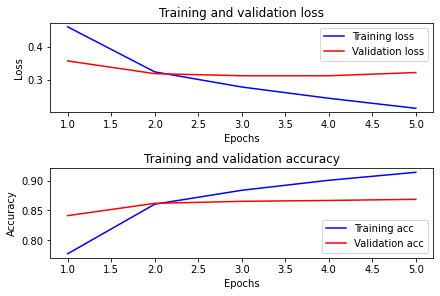

In [71]:
# Subplot들의 간격 조정하기 참고: https://tempdev.tistory.com/35

# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

In [72]:
word_vectors.similar_by_word("재미")

[('스토리', 0.4149767756462097),
 ('긴장감', 0.4109301269054413),
 ('완', 0.4071023464202881),
 ('감동', 0.4030129611492157),
 ('예뻐서', 0.4027698040008545),
 ('하늘', 0.3982482850551605),
 ('어울리', 0.39427632093429565),
 ('진짜', 0.39338165521621704),
 ('는데', 0.39296314120292664),
 ('깊이', 0.3925923705101013)]

In [73]:
word_vectors.similar_by_word("최고")

[('누군가', 0.36325740814208984),
 ('당대', 0.3536795377731323),
 ('수작', 0.33141815662384033),
 ('아날로그', 0.314446359872818),
 ('바치', 0.31333059072494507),
 ('곡', 0.31100383400917053),
 ('의외로', 0.31060802936553955),
 ('공권력', 0.30855754017829895),
 ('감수성', 0.30527111887931824),
 ('잼따', 0.2995571196079254)]

In [74]:
word_vectors.similar_by_word("별로")

[('어설픈', 0.5763288736343384),
 ('진부', 0.5739359855651855),
 ('-_', 0.5682641863822937),
 ('표절', 0.5643913149833679),
 ('짱나', 0.5627702474594116),
 ('그지', 0.5605618953704834),
 ('어휴', 0.5605323314666748),
 ('뻔한', 0.5575464963912964),
 ('별루', 0.5521450042724609),
 ('난해', 0.5379496812820435)]

In [75]:
word_vectors.similar_by_word("엉엉")

[('감회', 0.45710986852645874),
 ('정화', 0.45638078451156616),
 ('는다는', 0.4455082416534424),
 ('이뻐', 0.4291670620441437),
 ('연락', 0.4234762489795685),
 ('최고봉', 0.4205551743507385),
 ('발견', 0.4170006513595581),
 ('다가왔', 0.41380515694618225),
 ('감탄', 0.40907543897628784),
 ('힐링', 0.4064022898674011)]

In [76]:
word_vectors.similar_by_word("매력")

[('나루토', 0.46137771010398865),
 ('게', 0.4294614791870117),
 ('롭', 0.42611876130104065),
 ('바랍니다', 0.41053926944732666),
 ('이쁜', 0.409149706363678),
 ('음', 0.40361204743385315),
 ('뮤', 0.3967868983745575),
 ('로맨스', 0.39550620317459106),
 ('시', 0.3941178321838379),
 ('미셸', 0.39407801628112793)]

In [77]:
word_vectors.similar_by_word("반전")

[('에서', 0.5754741430282593),
 ('는데', 0.5681638121604919),
 ('하', 0.547177791595459),
 ('봤', 0.5454105138778687),
 (',', 0.5425621271133423),
 ('롭', 0.5361525416374207),
 ('숨겨진', 0.5272085666656494),
 ('기억', 0.5176573991775513),
 ('너무', 0.5171259641647339),
 ('영화', 0.516504168510437)]

- 비교

|Num|Model|Loss|Accuracy|
|:---:|:---:|:---:|:---:|
|1|LSTM|0.3595|0.8507|
|2|ko.bin 임베딩을 활용한 LSTM|0.3288|0.8648|

- 결론
  - 앞서 진행한 LSTM 모델과 카피한 임베딩을 활용한 LSTM 모델의 loss 와 accuracy 를 비교하면 후자가 더 성능이 좋다.
  - 유사 단어 찾기는 두 모델 모두 비슷하게 잘 찾아냈다.

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
- 라이브러리 때문에 시간을 버려서 굉장히 화났다. 클라우드 환경이 불난 집에 기름을 들이부었다. 매우 화난다.
- ko.bin 파일을 불러오는 기존의 lms 코드가 오류나서 해결하기까지 시간이 걸렸다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
1. 윈도우는 라이브러리 지원이 안 되는 경우(e.g. KoNLPy의 Mecab)가 종종 있다.
2. 라이브러리, 운영체제, 파이썬 버전 모든 것이 호환돼야 설치가 잘 진행된다.
3. 설치와 실행(import)은 별개다. 설치가 무사히 끝났어도 실행이 안 될 수가 있다.
3. ko.bin 파일을 불러올 때 Word2Vec.load() 코드로 바꿔 써야 제대로 동작했다.
4. padding 추가는 post 보다 pre 가 더 효율적이다. (RNN 모델의 경우, 입력데이터가 순차 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다.)

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|평가문항|상세기준|
>|:---:|:---:|
>|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
>|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
>|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

Model 3가지 비교는 기존 lms 코드를 그대로 썼다. 사용한 모델은 LSTM, 1-D CNN, GlobalMaxPooling1D() 레이어 1개이다. 구글링해보니 적절한 epoch 값은 early_stopping 인 시점이라고 해서 적용해 보았다. model.fit() 속도가 너무 느리고 학습할수록 validation_loss 값이 올라가서 기존 epochs=20 에서 5로 값을 낮췄다. epoch이 20이었을 때보다 훨씨니 안정적으로 변했다.

gensim으로 유사 단어 찾기를 해봤다. 일반 단어보다 감정 관련 단어여야 잘 찾아냈다. 그 중에서 부정적인 감정 단어(e.g. '별로')를 잘 추출해냈다.

기존의 LSTM 모델보다 ko.bin 임베딩을 활용한 LSTM 성능이 더 좋았음을 확인했다.

### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
- 클라우드 환경은 한번씩 둘러봐야 한다. 보고 있어도 연결 끊기는 건 함정 ^^
- 그러므로 클라우드 환경에서 작업한 주피터 노트북 파일을 자주 다운받아서 로컬에 저장해놔야 한다.

---

- 대나무숲

예전부터 lms 할 때마다 로컬 컴퓨터에서 패키지 설치가 안 되어서 난항을 겪었는데 이번 노드에서 제대로 포텐 터졌다. 빨간색 글자로 도배된 Error와 끝이 보이지 않는 Examining의 늪에 빠졌다. 어처구니가 없다 정말. 요즘 손가락이 너무 아프다. 이게 마음가짐으로 해결되는 것도 아니고 서럽네. 이정도면 감정 분석의 대상이 사실 내가 아니었을까? 라는 생각이 든다.

- 화났음!

항상 로컬에서만 작업해왔기에 이번에도 로컬 컴퓨터에서 하려고 라이브러리 설치부터 시도했다. 그러나 KoNLPy 공식 홈페이지에서 안내하기로 윈도우에서는 Mecab 을 지원하지 않는다고 되어 있었다. 현재 내 파이썬 버전이 lms 클라우드 환경과 동일한 3.9.7 버전인데 3.8.x 버전으로 다운그레이드해야 윈도우에서 사용할 수 있다고 되어 있다. 주말을 투자했으나 아나콘다 패키지가 꼬였는지 Examining 만 이틀 넘게 돌아가고 있어서 실패했다. 심지어 지금도 돌아가고 있다. 그렇게 로컬 컴퓨터에서 하겠다는 계획은 박살났다. GPU 사용하려고 CUDA까지 다 설정해놔서 그런 것인지 원인이 무엇인지 감을 잡을 수가 없다. 제출할 시간은 다가오고 마음이 급해서 lms에서 하려고 해봤으나 lms 오류가 나서 리셋이 됐고 다 날아가버렸다. 수업 시간 때에도 한번씩 OoOoOOOoooh!! 글자가 나타나면서 404 error 페이지가 날 반길 때가 자주 있었는데 그 화면을 이렇게 급할 때 또 보니 정말 부수고 싶었다. Colab 으로 왔으나 여기서도 이놈의 KoNLPy와 MeCab 설정하느라 머리가 아팠다. KoNLPy가 되면 MeCab이 안 되고 MeCab이 되면 KoNLPy가 안 되는 어이 없는 현상이 나타나서 해결하느라 결국 시간이 또 많이 걸렸다. Colab 런타임 GPU 설정을 했어도 model.fit() 코드 실행 속도가 느려서 매우 화났다. 한번씩 Colab 연결이 끊어져서 실행했던 내역이 싹 증발해서 처음부터 다시 실행하느라 분노폭발했다.